In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [35]:
sales = pd.read_csv("sales_train_validation.csv")
calendar = pd.read_csv("calendar.csv")
prices = pd.read_csv("sell_prices.csv")
holidays = pd.read_csv("holidays.csv", encoding='ISO-8859-1')

In [ ]:
sales_long = sales.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                        var_name='day', value_name='sales')
sales_long = sales_long.merge(calendar, how='left', left_on='day', right_on='d')
sales_long = sales_long.merge(prices, how='left', on=['store_id', 'item_id', 'wm_yr_wk'])
sales_long = sales_long.merge(holidays, on='date', how='left')

In [ ]:
sales_long['date'] = pd.to_datetime(sales_long['date'])
df = sales_long.groupby('date')['sales'].sum().reset_index()

In [ ]:
if 'holiday_name' in sales_long.columns:
    df['is_holiday'] = sales_long.groupby('date')['holiday_name'].first().notnull().astype(int).values
else:
    df['is_holiday'] = 0

In [ ]:
scaler = MinMaxScaler()
df['scaled_sales'] = scaler.fit_transform(df[['sales']])

In [ ]:
df['weekday'] = df['date'].dt.weekday
df['scaled_weekday'] = MinMaxScaler().fit_transform(df[['weekday']])
df['lag_1'] = df['scaled_sales'].shift(1)
df['lag_7'] = df['scaled_sales'].shift(7)
df = df.dropna().reset_index(drop=True)

In [ ]:
def create_multifeature_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq_x = data.iloc[i:i+seq_length][['scaled_sales', 'scaled_weekday', 'is_holiday', 'lag_1', 'lag_7']].values
        seq_y = data.iloc[i+seq_length]['scaled_sales']
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

SEQ_LEN = 30
X, y = create_multifeature_sequences(df, SEQ_LEN)

In [43]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [42]:
def flatten_X_for_xgb(X_seq):
    return X_seq.reshape((X_seq.shape[0], -1))

X_train_xgb = flatten_X_for_xgb(X_train)
X_test_xgb = flatten_X_for_xgb(X_test)

In [50]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

xgb = XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=1)
grid_search.fit(X_train_xgb, y_train)

print("Best Parameters:", grid_search.best_params_)
xgb_model = grid_search.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [59]:
xgb_pred = xgb_model.predict(X_test_xgb)
xgb_pred_rescaled = scaler.inverse_transform(xgb_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_log_error, median_absolute_error


xgb_msle = mean_squared_log_error(y_test_rescaled.ravel(), xgb_pred_rescaled.ravel())
xgb_medae = median_absolute_error(y_test_rescaled, xgb_pred_rescaled)
xgb_max_error = np.max(np.abs(y_test_rescaled - xgb_pred_rescaled))

print(f"Mean Squared Log Error (XGBoost): {xgb_msle:.4f}")
print(f"Median Absolute Error (XGBoost): {xgb_medae:.2f}")
print(f"Max Error (XGBoost): {xgb_max_error:.2f}")


Mean Squared Log Error (XGBoost): 0.1673
Median Absolute Error (XGBoost): 1685.64
Max Error (XGBoost): 35717.59


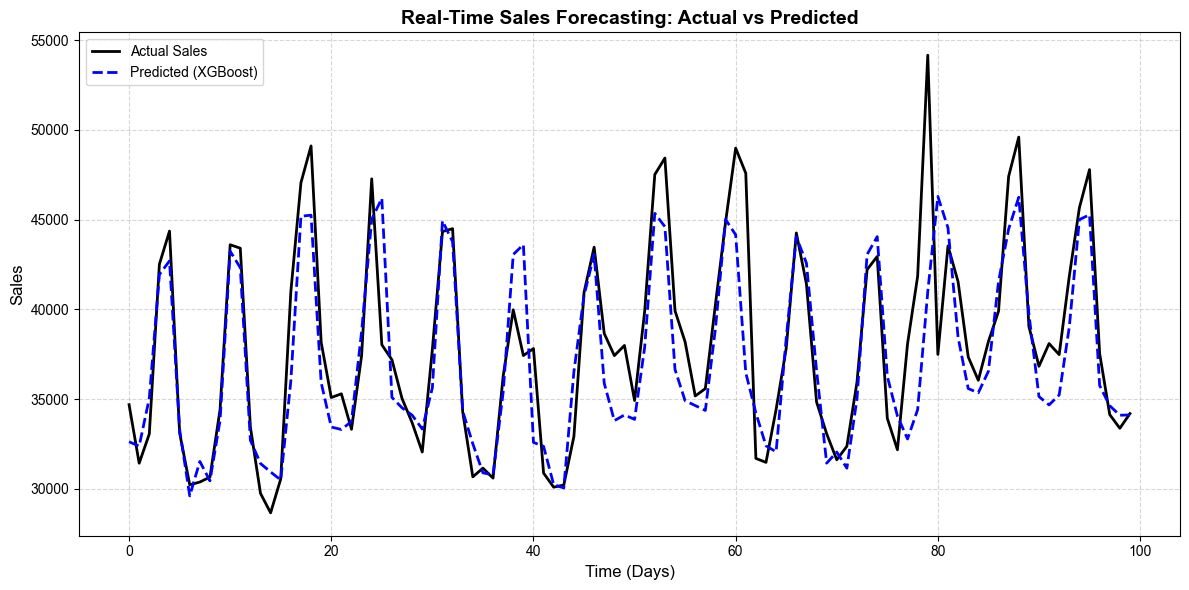

In [63]:
# 📈 Enhanced Visualization: Actual vs Predicted
plt.figure(figsize=(12, 6))

plt.plot(y_test_rescaled[:100], label='Actual Sales', color='black', linewidth=2)
plt.plot(xgb_pred_rescaled[:100], label='Predicted (XGBoost)', color='blue', linestyle='--', linewidth=2)

plt.grid(True, linestyle='--', alpha=0.5)
plt.title("Real-Time Sales Forecasting: Actual vs Predicted", fontsize=14, weight='bold')
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [48]:
results_df = pd.DataFrame({
    'Actual': y_test_rescaled.flatten(),
    'Predicted': xgb_pred_rescaled.flatten()
})
results_df.to_csv("xgb_forecast_results.csv", index=False)
print("Results saved to xgb_forecast_results.csv")

Results saved to xgb_forecast_results.csv
